# SDFusion: Text-guided Generation (txt2shape)

### TODO: add sample results or teaser images

In [2]:
# first set up which gpu to use
import os
gpu_ids = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_ids}"

In [3]:
# import libraries
import numpy as np
from IPython.display import Image as ipy_image
from IPython.display import display
from termcolor import colored, cprint

import torch
print(torch.cuda.is_available())
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
import torchvision.utils as vutils

from models.base_model import create_model
from utils.util_3d import render_sdf, render_mesh, sdf_to_mesh, save_mesh_as_gif

%load_ext autoreload
%autoreload 2

True


In [4]:
# options for the model. please check `utils/demo_util.py` for more details
from utils.demo_util import SDFusionText2ShapeOpt

seed = 2023
opt = SDFusionText2ShapeOpt(gpu_ids=gpu_ids, seed=seed)
device = opt.device

[*] SDFusionText2ShapeOption initialized.


In [5]:
# enable proxy for huggingface

import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [6]:
# initialize SDFusion model
# ckpt_path = 'saved_ckpt/sdfusion-txt2shape.pth'
ckpt_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-04-05T17-15-19-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth'
vqvae_path = '/root/autodl-tmp/SDFusion/logs_home/continue-2024-03-27T11-26-32-vqvae-snet-all-res64-LR1e-4-T0.2-release/ckpt/vqvae_epoch-best.pth'
opt.init_model_args(ckpt_path=ckpt_path, vq_ckpt_path=vqvae_path)

SDFusion = create_model(opt)
cprint(f'[*] "{SDFusion.name()}" loaded.', 'cyan')

Working with z of shape (1, 3, 16, 16, 16) = 12288 dimensions.
[*] VQVAE: weight successfully load from: /root/autodl-tmp/SDFusion/logs_home/continue-2024-03-27T11-26-32-vqvae-snet-all-res64-LR1e-4-T0.2-release/ckpt/vqvae_epoch-best.pth
[*] weight successfully load from: /root/autodl-tmp/SDFusion/logs_home/continue-2024-04-05T17-15-19-sdfusion-txt2shape-text2shape-all-LR1e-5-clean-code/ckpt/df_steps-latest.pth
[*] setting ddim_steps=100
[*] Model has been created: SDFusion-Text2Shape-Model
[*] "SDFusion-Text2Shape-Model" loaded.


## SDFusion: text-guided generation (txt2shape)

In [7]:
import pytorch3d

# load a mesh
mesh_path = ['/root/autodl-tmp/SDFusion/data/ShapeNet/SoftNetModels/01/a3/model.obj']
# mesh_path = ['/root/autodl-tmp/SDFusion/test_results_pretrained_small_dset/obj/txt2shape-articulated zigzag fold-based 1dof directional bending soft actuator-35.obj']
mesh = pytorch3d.io.load_objs_as_meshes(mesh_path, device=device)
# resize the mesh
# scale the largest dimension to 1
bounding_box = mesh.get_bounding_boxes()
max_size = (bounding_box[:, :, 1] - bounding_box[:, :, 0]).max()
mesh = mesh.scale_verts(1.0 / max_size.item())
# move the mesh to the center
center = mesh.get_bounding_boxes().mean(2)[0]
mesh = mesh.offset_verts(-center)

mesh_gen = mesh[0]
# vis as gif
gen_name = f'/root/autodl-tmp/SDFusion/test_results_pretrained_small_dset/gt_gifs/a.gif'
save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

for name in [gen_name]:
    display(ipy_image(name))

FileNotFoundError: [Errno 2] No such file or directory: '/root/autodl-tmp/SDFusion/data/ShapeNet/SoftNetModels/01/a3/model.obj'

Generated for a9.


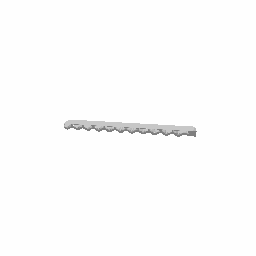

In [9]:
import pytorch3d
from utils.util_3d import rotate_mesh

# load a mesh
mesh_dir = '/root/autodl-tmp/SDFusion/data/ShapeNet/ShapeNetCore.v1/01'

for folder in os.listdir(mesh_dir):
    if folder.startswith('a')

        mesh_path = [os.path.join(mesh_dir, folder, 'model.obj')]
        mesh = pytorch3d.io.load_objs_as_meshes(mesh_path, device=device)
        # resize the mesh
        # scale the largest dimension to 1
        bounding_box = mesh.get_bounding_boxes()
        max_size = (bounding_box[:, :, 1] - bounding_box[:, :, 0]).max()
        mesh = mesh.scale_verts(1.0 / max_size.item())
        # move the mesh to the center
        center = mesh.get_bounding_boxes().mean(2)[0]
        mesh = mesh.offset_verts(-center)

        mesh_gen = mesh[0]
        # vis as gif
        gen_name = f'/root/autodl-tmp/SDFusion/test_ground_truth/gifs/{folder}.gif'
        save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

        for name in [gen_name]:
            display(ipy_image(name))

        # make mesh upside down and render
        mesh_gen = rotate_mesh(mesh_gen, axis='X', angle=180)
        gen_name = f'/root/autodl-tmp/SDFusion/test_ground_truth/gifs/{folder}_upside_down.gif'
        save_mesh_as_gif(SDFusion.renderer, mesh_gen, nrow=3, out_name=gen_name)

        # clear output in the notebook
        from IPython.display import clear_output
        clear_output()
        print(f"Generated for {folder}.")
        for name in [gen_name]:
            display(ipy_image(name))